In [1]:
%env CUDA_VISIBLE_DEVICES=0
import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

import open3d as o3d
import numpy as np
import os
import glob
from matplotlib import pyplot as plt

from utils import *

env: CUDA_VISIBLE_DEVICES=0
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

In [3]:
use_scan_points = True
if use_scan_points:
    scan_path = "/root/autodl-tmp/facescape/scan/1.ply"
    scan_mesh = o3d.io.read_triangle_mesh(scan_path)
    scan_points = np.asarray(scan_mesh.vertices)
    point_all = scan_points
    color_all = np.ones_like(scan_points) * 0.6

In [4]:
# 此时point数量太多了，没法学，sample出30000个点
import random
sample_indices = random.sample(range(point_all.shape[0]), 30000)

points = point_all[sample_indices]
# colors = color_all[sample_indices]

In [12]:
# load target mesh
target_mesh = o3d.io.read_triangle_mesh("/root/autodl-tmp/facescape/mesh/1_ictcut.ply")
# target_mesh = o3d.io.read_triangle_mesh("/root/autodl-tmp/facescape/result/exp1/1_neutral.ply")
faces = np.asarray(target_mesh.triangles)
vertices = np.asarray(target_mesh.vertices)

In [15]:
import pickle
uvs = pickle.load(open("/root/autodl-tmp/facescape/template/ict_template_cut_uvs.pkl", "rb"))

In [16]:
uvs_array = np.zeros((uvs.keys().__len__(), 2), dtype=np.float32)
for i in range(uvs.keys().__len__()):
    uvs_array[i, 0] = uvs[i][0]
    uvs_array[i, 1] = uvs[i][1]

In [19]:
# 计算出所有points的uv GT和point_prob_gt
import trimesh
from trimesh.proximity import closest_point
from trimesh.triangles import points_to_barycentric
# build a target trimesh
target_trimesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False)
# closest_points, distances, face_indices = closest_point(target_trimesh, points)
# # get triangles according to face_indices
# triangles = target_trimesh.faces[face_indices]
# triangles = target_trimesh.vertices[triangles]
# closet_points_barycentric = points_to_barycentric(triangles, closest_points)
# # get uvs according to barycentric coordinates
# triangles = target_trimesh.faces[face_indices]
# uvs_gt = (closet_points_barycentric[...,None] * uvs_array[triangles]).sum(1)

In [20]:
# get boundary edges of the target mesh
unique_edges = target_trimesh.edges[trimesh.grouping.group_rows(target_trimesh.edges_sorted, require_count=1)]

In [21]:
# get connected component of unique edges
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
edges = np.array(unique_edges)
# get all unique vertices in edges
vertices_edge = np.unique(edges)
# create a map between vertices_edge and 0-len(vertices_edge)
vertex_map = {v: i for i, v in enumerate(vertices_edge)}
vertex_map_reverse = {i: v for i, v in enumerate(vertices_edge)}
edges_map = np.array([[vertex_map[v1], vertex_map[v2]] for v1, v2 in edges])
# create a matrix
graph = csr_matrix((np.ones(edges_map.shape[0]), (edges_map[:, 0], edges_map[:, 1])), shape=(len(vertices_edge), len(vertices_edge)))
# get connected components
n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
output_components = {}
for i in range(n_components):
    output_components[i] = vertices_edge[labels == i]
# get the largest connected component
largest_component = max(output_components.values(), key=len)
# get the vertices in the largest component
largest_component_set = list(set(largest_component))
boundary_vertices = largest_component_set

In [24]:
# save boundary vertices using pickle
import pickle
boundary_vertices_path = "/root/autodl-tmp/facescape/template/boundary_vertices.pkl"

pickle.dump(boundary_vertices, open(boundary_vertices_path, "wb"))

In [11]:
from scipy.spatial import ConvexHull

# point_prob_gt = []
# uvs_array_hull = ConvexHull(uvs_array)
# border_vertices = list(uvs_array_hull.vertices)
# for i in range(len(closest_points)):
#     triangle_bary = closet_points_barycentric[i]
#     triangle = triangles[i]
#     if triangle_bary.min() < 1e-6:
#         # get the second min value
#         second_min = triangle_bary[np.argsort(triangle_bary)[1]]
#         if second_min < 1e-6:
#             # get the index of the max value
#             max_ind = triangle_bary.argmax()
#             max_ind = triangle[max_ind]
#             if max_ind in boundary_vertices:
#                 point_prob_gt.append(False)
#                 continue
#         min_ind = triangle_bary.argmin()
#         if min_ind == 0:
#             test_indices = [triangle[1], triangle[2]]
#         elif min_ind == 1:
#             test_indices = [triangle[0], triangle[2]]
#         else:
#             test_indices = [triangle[0], triangle[1]]
#         if test_indices[0] in boundary_vertices and test_indices[1] in boundary_vertices:
#             point_prob_gt.append(False)
#         else:
#             point_prob_gt.append(True)
#     else:
#         point_prob_gt.append(True)
# point_prob_gt = np.array(point_prob_gt)

In [194]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
colors = apply_color_map(point_prob_gt.astype(np.float32), cmap="viridis")
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/points_mesh.ply", pcd)

True

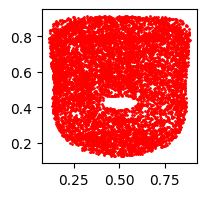

In [197]:
plt.figure(figsize=(2, 2))
plt.scatter(uvs_gt[point_prob_gt][:, 0], uvs_gt[point_prob_gt][:, 1], s=1, c='r', label='GT UVs')

In [204]:
point_prob_gt = point_prob_gt.astype(np.float32)

In [12]:
# 对points进行参数化，使用uvp的方式
%load_ext autoreload
%autoreload 2
from networks import *

point_uvs_ = torch.nn.Parameter(torch.randn((points.shape[0], 2), device=device))
point_prob_ = torch.nn.Parameter(torch.zeros((points.shape[0]), device=device))

distance_to_weights = FFMLP(in_dim=1, hidden_dim=64, out_dim=1, activation=None).to(device)

In [201]:
optimizer = torch.optim.Adam([
    {'params': point_uvs_, "lr": 0.01},
    {'params': point_prob_, "lr": 0.01},
    {'params': distance_to_weights.parameters(), "lr": 0.001}
])

In [211]:
from tqdm import trange

epochs = 10000
summary_writer = SummaryWriter()

if type(uvs_array) == np.ndarray:
    uvs_array = torch.from_numpy(uvs_array).to(device) # K, 2
if type(points) == np.ndarray:
    points = torch.from_numpy(points).to(device) # 30000, 3
if type(vertices) == np.ndarray:
    vertices = torch.from_numpy(vertices).to(device) # num_vertices, 3
if type(uvs_gt) == np.ndarray:
    uvs_gt = torch.from_numpy(uvs_gt).to(device) # 30000, 2
if type(point_prob_gt) == np.ndarray:
    point_prob_gt = torch.from_numpy(point_prob_gt).to(device) # 30000

for epoch in (tbar:=trange(epochs)):
    point_uvs = point_uvs_.sigmoid() # sigmoid to ensure uvs in [0, 1]
    point_prob = point_prob_.sigmoid() # sigmoid to ensure prob in [0, 1]
    
    loss_uvs = torch.nn.functional.mse_loss(point_uvs, uvs_gt.float(), reduction='mean')
    loss_prob = torch.nn.functional.binary_cross_entropy(point_prob, point_prob_gt.float(), reduction='mean')
    
    # # get the distance matrix of point_uvs to uvs_array, assume uvs_array has K points and point_uvs has 30000 points
    # distance_matrix = torch.cdist(uvs_array, point_uvs, p=2) # K, 30000
    # # weight_matrix = 1 / (distance_matrix + 1e-6) # K, 30000
    # # weight_matrix = weight_matrix * point_prob.unsqueeze(0) # K, 30000
    # # weight_matrix = weight_matrix / weight_matrix.sum(dim=1, keepdim=True) # K, 30000
    # weight_matrix = distance_to_weights(distance_matrix.unsqueeze(2)) # K, 30000, 1
    # weight_matrix = weight_matrix.squeeze(2) # K, 30000
    # weight_matrix = torch.nn.functional.softmax(weight_matrix, dim=0) # K, 30000
    
    # predict_vertices = weight_matrix @ points.float() # 30000, 3
    
    loss = loss_uvs + loss_prob
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    tbar.set_description(f"Loss: {loss.item():.4f}, Loss_UVs: {loss_uvs.item():.4f}, Loss_Prob: {loss_prob.item():.4f}")
    summary_writer.add_scalar("loss", loss.item())
    summary_writer.add_scalar("loss_uvs", loss_uvs.item())
    summary_writer.add_scalar("loss_prob", loss_prob.item())

Loss: 0.0000, Loss_UVs: 0.0000, Loss_Prob: 0.0000: 100%|██████████| 10000/10000 [00:41<00:00, 241.21it/s]


In [213]:
from matplotlib import cm
from matplotlib import pyplot as plt
def apply_color_map(data,cmap = 'viridis', vmin=None, vmax=None):
    data = np.array(data)
    if vmin is None:
        v_min = np.min(data)
    if vmax is None:
        v_max = np.max(data)
    return getattr(cm,cmap)(plt.Normalize(vmin,vmax)(data))[...,:3]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points.detach().cpu().numpy())
pcd.colors = o3d.utility.Vector3dVector(apply_color_map(point_prob.detach().cpu().numpy(), cmap='viridis'))

o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/sample_points.ply", pcd)

# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(predict_vertices.detach().cpu().numpy())
# o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/points_mesh.ply", pcd)

True

### 看看在这里能不能学习得到一个从feature到uv和prob的映射

In [3]:
%load_ext autoreload
%autoreload 2
from networks import *
import pickle
from tqdm import trange,tqdm
import trimesh
from trimesh.proximity import closest_point
from trimesh.triangles import points_to_barycentric

In [4]:
uvs = pickle.load(open("/root/autodl-tmp/facescape/template/ict_template_cut_uvs.pkl", "rb"))

uvs_array = np.zeros((uvs.keys().__len__(), 2), dtype=np.float32)
for i in range(uvs.keys().__len__()):
    uvs_array[i, 0] = uvs[i][0]
    uvs_array[i, 1] = uvs[i][1]

boundary_vertices_path = "/root/autodl-tmp/facescape/template/boundary_vertices.pkl"
boundary_vertices = pickle.load(open(boundary_vertices_path, "rb"))

In [5]:
def get_gt(points, target_mesh):
    # examine target_mesh type, if it is o3d.geometry.TriangleMesh, convert it to trimesh
    if isinstance(target_mesh, o3d.geometry.TriangleMesh):
        # convert o3d.geometry.TriangleMesh to trimesh
        faces = np.asarray(target_mesh.triangles)
        vertices = np.asarray(target_mesh.vertices)
        target_trimesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False)
    else:
        target_trimesh = target_mesh
    
    # get uvs_gt and point_prob_gt
    closest_points, distances, face_indices = closest_point(target_trimesh, points)
    # get triangles according to face_indices
    triangles = target_trimesh.faces[face_indices]
    triangles = target_trimesh.vertices[triangles]
    closet_points_barycentric = points_to_barycentric(triangles, closest_points)
    # get uvs according to barycentric coordinates
    triangles = target_trimesh.faces[face_indices]
    uvs_gt = (closet_points_barycentric[...,None] * uvs_array[triangles]).sum(1)
    

    point_prob_gt = []
    for i in (tbar:=range(points.shape[0])):
        # tbar.set_description(f"Processing point")
        triangle_bary = closet_points_barycentric[i]
        triangle = triangles[i]
        if triangle_bary.min() < 1e-6:
            # get the second min value
            second_min = triangle_bary[np.argsort(triangle_bary)[1]]
            if second_min < 1e-6:
                # get the index of the max value
                max_ind = triangle_bary.argmax()
                max_ind = triangle[max_ind]
                if max_ind in boundary_vertices:
                    point_prob_gt.append(False)
                    continue
            min_ind = triangle_bary.argmin()
            if min_ind == 0:
                test_indices = [triangle[1], triangle[2]]
            elif min_ind == 1:
                test_indices = [triangle[0], triangle[2]]
            else:
                test_indices = [triangle[0], triangle[1]]
            if test_indices[0] in boundary_vertices and test_indices[1] in boundary_vertices:
                point_prob_gt.append(False)
            else:
                point_prob_gt.append(True)
        else:
            point_prob_gt.append(True)
    point_prob_gt = np.array(point_prob_gt, dtype=np.float32)
    return uvs_gt, point_prob_gt

In [6]:
identities = [2,6,9,13,19,20,21,22]
identities = [2]
identities = list(range(1,31))

n_identities = len(identities)

In [7]:
points_dataset = []
features_dataset = []
target_trimesh_dataset = []
for identity in tqdm(identities):
    all_points = np.load(f"/root/autodl-tmp/facescape/all_features/{identity}/all_points.npy")
    all_features = np.load(f"/root/autodl-tmp/facescape/all_features/{identity}/all_features.npy")
    target_mesh = o3d.io.read_triangle_mesh(f"/root/autodl-tmp/facescape/mesh/{identity}_ictcut.ply")
    target_trimesh = trimesh.Trimesh(vertices=np.asarray(target_mesh.vertices), faces=np.asarray(target_mesh.triangles), process=False)
    points_dataset.append(all_points)
    features_dataset.append(all_features)
    target_trimesh_dataset.append(target_trimesh)

100%|██████████| 30/30 [00:54<00:00,  1.82s/it]


In [8]:
uvs_dataset = []
point_prob_dataset = []
for identity in tqdm(identities):
    masks = []
    uvs = []
    point_prob = []
    n_items = os.listdir(f"/root/autodl-tmp/facescape/mask/{identity}").__len__()
    for i in range(n_items):
        mask = np.load(f"/root/autodl-tmp/facescape/mask/{identity}/{i}.npy")
        uv = np.load(f"/root/autodl-tmp/facescape/uvs/{identity}/{i}.npy")
        pp = np.load(f"/root/autodl-tmp/facescape/point_prob/{identity}/{i}.npy")
        masks.append(mask)
        uvs.append(uv)
        point_prob.append(pp)
    masks = np.array(masks)
    uvs = np.array(uvs)
    point_prob = np.array(point_prob)
    uvs = uvs[masks>0]
    point_prob = point_prob[masks>0]
    uvs_dataset.append(uvs)
    point_prob_dataset.append(point_prob)

100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


In [14]:
from tensorboardX import SummaryWriter as SummaryWriterTS
# feature_mlp = FFMLP(in_dim=128, hidden_dim=256, out_dim=3, activation='sigmoid').to(device)
feature_mlp = HugeMLP(128,256,3,activation="sigmoid").to("cuda")
summary_writer = SummaryWriterTS("runs/50persons_lr0.001_hugeMLP")

In [15]:
optimizer = torch.optim.Adam(feature_mlp.parameters(), lr=0.001)

In [16]:
import random
from tqdm import trange

global_steps = 40000
n_persons_per_step = 5


for global_step in (tbar:=trange(global_steps)):
    # random select an item index from dataset
    item_indices = random.sample(range(n_identities), n_persons_per_step)
    features_batch = []
    uvs_batch = []
    point_prob_batch = []
    for item_index in item_indices:
        # all_points = points_dataset[item_index]  # N, 3
        all_features = features_dataset[item_index]  # N, 128
        target_trimesh = target_trimesh_dataset[item_index]  # trimesh object
    
        # ramdom sample 30000 points
        sample_indices = random.sample(range(all_features.shape[0]), 30000)
        # points = all_points[sample_indices]  # 30000, 3
        features = all_features[sample_indices]  # 30000, 128
        
        # uvs_gt, point_prob_gt = get_gt(points, target_trimesh)  # 30000, 2 and 30000
        uvs_gt = uvs_dataset[item_index]  # N, 2
        uvs_gt = uvs_gt[sample_indices]  # 30000, 2
        point_prob_gt = point_prob_dataset[item_index]  # N
        point_prob_gt = point_prob_gt[sample_indices]  # 30000
        
        features_batch.append(features)
        uvs_batch.append(uvs_gt)
        point_prob_batch.append(point_prob_gt)
    features_batch = np.concatenate(features_batch, axis=0)  # (n_persons_per_step * 30000, 128)
    uvs_batch = np.concatenate(uvs_batch, axis=0)  # (n_persons_per_step * 30000, 2)
    point_prob_batch = np.concatenate(point_prob_batch, axis=0)  # (n_persons_per_step * 30000,)
    
    predict_output = feature_mlp(torch.from_numpy(features_batch).to(device).float())  # 30000, 3
    predict_uvs = predict_output[..., :2]  # 30000, 2
    predict_prob = predict_output[..., 2]  # 30000
    
    # we do not need to calculate the loss_uvs on those points which prob is 0
    valid_indices = point_prob_batch > 0.5
    loss_uvs = torch.nn.functional.mse_loss(predict_uvs[valid_indices], torch.from_numpy(uvs_batch[valid_indices]).to(device).float(), reduction='mean')
    loss_prob = torch.nn.functional.binary_cross_entropy(predict_prob, torch.from_numpy(point_prob_batch).to(device).float(), reduction='mean')
    loss = loss_uvs + loss_prob
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    
    tbar.set_description(f"Loss: {loss.item():.4f}, Loss_UVs: {loss_uvs.item():.4f}, Loss_Prob: {loss_prob.item():.4f}")
    summary_writer.add_scalar("loss", loss.item(), global_step)
    summary_writer.add_scalar("loss_uvs", loss_uvs.item(), global_step)
    summary_writer.add_scalar("loss_prob", loss_prob.item(), global_step)
    summary_writer.flush()

        
    if global_step % 100 == 0:
        # save the model
        torch.save(feature_mlp.state_dict(), f"/root/autodl-tmp/facescape/result/uvs/30persons_hugeMLP/checkpoints/{global_step}.pth")

Loss: 0.0117, Loss_UVs: 0.0011, Loss_Prob: 0.0106: 100%|██████████| 40000/40000 [4:56:26<00:00,  2.25it/s]  


In [17]:
# save the final model
torch.save(feature_mlp.state_dict(), "/root/autodl-tmp/facescape/result/uvs/1persons_featureMLP/checkpoints/final.pth")

In [344]:
# load the model
state_dict = torch.load("/root/autodl-tmp/facescape/result/uvs/8persons_featureMLP/checkpoints/9900.pth")
feature_mlp.load_state_dict(state_dict)

/tmp/ipykernel_20468/2157820096.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/root/autodl-tmp/facescape/result/uvs/8persons_featureMLP/checkp

<All keys matched successfully>

In [69]:
# view test loss
test_identities = list(range(1,51))
features_test_dataset = []
uvs_test_dataset = []
point_prob_test_dataset = []
for identity in tqdm(test_identities):
    all_features = np.load(f"/root/autodl-tmp/facescape/all_features/{identity}/all_features.npy")
    masks = []
    uvs = []
    point_prob = []
    n_items = os.listdir(f"/root/autodl-tmp/facescape/mask/{identity}").__len__()
    for i in range(n_items):
        mask = np.load(f"/root/autodl-tmp/facescape/mask/{identity}/{i}.npy")
        uv = np.load(f"/root/autodl-tmp/facescape/uvs/{identity}/{i}.npy")
        pp = np.load(f"/root/autodl-tmp/facescape/point_prob/{identity}/{i}.npy")
        masks.append(mask)
        uvs.append(uv)
        point_prob.append(pp)
    masks = np.array(masks)
    uvs = np.array(uvs)
    point_prob = np.array(point_prob)
    uvs = uvs[masks>0]
    point_prob = point_prob[masks>0]
    assert uvs.shape[0] == point_prob.shape[0]
    assert all_features.shape[0] == uvs.shape[0]
    sample_indices = random.sample(range(all_features.shape[0]), 30000)
    features_test_dataset.append(all_features[sample_indices])
    uvs_test_dataset.append(uvs[sample_indices])
    point_prob_test_dataset.append(point_prob[sample_indices])
features_test_dataset = np.concatenate(features_test_dataset, axis=0)  # (n_persons_per_step * 30000, 128)
uvs_test_dataset = np.concatenate(uvs_test_dataset, axis=0)  # (n_persons_per_step * 30000, 2)
point_prob_test_dataset = np.concatenate(point_prob_test_dataset, axis=0)  # (n_persons_per_step * 30000,)
# 前60%是train set，后40%是test set
features_train_dataset = features_test_dataset[:int(features_test_dataset.shape[0]*0.6)]
features_test_dataset = features_test_dataset[int(features_test_dataset.shape[0]*0.6):]
uvs_train_dataset = uvs_test_dataset[:int(uvs_test_dataset.shape[0]*0.6)]
uvs_test_dataset = uvs_test_dataset[int(uvs_test_dataset.shape[0]*0.6):]
point_prob_train_dataset = point_prob_test_dataset[:int(point_prob_test_dataset.shape[0]*0.6)]
point_prob_test_dataset = point_prob_test_dataset[int(point_prob_test_dataset.shape[0]*0.6):]

100%|██████████| 50/50 [01:51<00:00,  2.24s/it]


In [70]:
loss_uvs_records_test = {}
loss_prob_records_test = {}
loss_prob_records_train = {}
loss_uvs_records_train = {}

feature_mlp = MLPwithSkip(128,256,3,D=8, skips=[4],activation='sigmoid').to(device)
for i in trange(0,40000,100):
    _ = feature_mlp.load_state_dict(torch.load(f"/root/autodl-tmp/facescape/result/uvs/30persons_skip/checkpoints/{i}.pth"))
    with torch.no_grad():
        predict_output = feature_mlp(torch.from_numpy(features_test_dataset).to(device).float())  # 30000, 3
        predict_uvs = predict_output[..., :2]  # 30000, 2
        predict_prob = predict_output[..., 2]  # 30000
        valid_indices = point_prob_test_dataset > 0.5
        loss_uvs = torch.nn.functional.mse_loss(predict_uvs[valid_indices], torch.from_numpy(uvs_test_dataset[valid_indices]).to(device).float(), reduction='mean')
        loss_prob = torch.nn.functional.binary_cross_entropy(predict_prob, torch.from_numpy(point_prob_test_dataset).to(device).float(), reduction='mean')
        loss_uvs_records_test[i] = loss_uvs.item()
        loss_prob_records_test[i] = loss_prob.item()
        
        predict_output = feature_mlp(torch.from_numpy(features_train_dataset).to(device).float())  # 30000, 3
        predict_uvs = predict_output[..., :2]
        predict_prob = predict_output[..., 2]
        valid_indices = point_prob_train_dataset > 0.5
        loss_uvs = torch.nn.functional.mse_loss(predict_uvs[valid_indices], torch.from_numpy(uvs_train_dataset[valid_indices]).to(device).float(), reduction='mean')
        loss_prob = torch.nn.functional.binary_cross_entropy(predict_prob, torch.from_numpy(point_prob_train_dataset).to(device).float(), reduction='mean')
        loss_uvs_records_train[i] = loss_uvs.item()
        loss_prob_records_train[i] = loss_prob.item()

  0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_1429/24239533.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _ = feature_mlp.load_state_dict(torch.load(f"/root/au

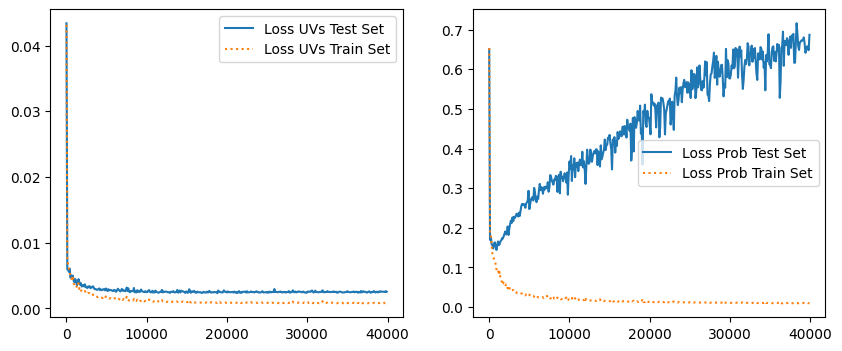

In [71]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(list(loss_uvs_records_test.keys()), list(loss_uvs_records_test.values()), label='Loss UVs Test Set')
plt.plot(list(loss_uvs_records_train.keys()), list(loss_uvs_records_train.values()), linestyle=':', label='Loss UVs Train Set')
plt.legend()
plt.subplot(1,2,2)
plt.plot(list(loss_prob_records_test.keys()), list(loss_prob_records_test.values()), label='Loss Prob Test Set')
plt.plot(list(loss_prob_records_train.keys()), list(loss_prob_records_train.values()), linestyle=':', label='Loss Prob Train Set')
plt.legend()

In [336]:
test_identity = 6
test_points = np.load(f"/root/autodl-tmp/facescape/all_features/{test_identity}/all_points.npy")
test_features = np.load(f"/root/autodl-tmp/facescape/all_features/{test_identity}/all_features.npy")

In [354]:
import random
sample_indices = random.sample(range(test_points.shape[0]), 100000)
points = test_points[sample_indices]  # 30000, 3
features = test_features[sample_indices]  # 30000, 128

features = torch.from_numpy(features).to(device).float()  # 30000, 128
with torch.no_grad():
    predict_output = feature_mlp(features)  # 30000, 3
    predict_uvs = predict_output[..., :2]  # 30000, 2
    predict_prob = predict_output[..., 2]  # 30000
    predict_uvs = predict_uvs.detach().cpu().numpy()  # 30000, 2
    predict_prob = predict_prob.detach().cpu().numpy()  # 30000

In [350]:
replace_with_gt = True
if replace_with_gt:
    predict_uvs = uvs_dataset[identities.index(test_identity)][sample_indices]
    predict_prob = point_prob_dataset[identities.index(test_identity)][sample_indices]

In [356]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

colors = apply_color_map(predict_prob, cmap='viridis')
pcd.colors = o3d.utility.Vector3dVector(colors)

o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/uvs/sample_points_prob.ply", pcd)

highlight_vertex = 4690
highlight_vertex_uv = uvs_array[highlight_vertex]
K = 10
# find the closest point to highlight_vertex_uv in predict_uvs
from scipy.spatial.distance import cdist
distance_matrix = cdist(predict_uvs, highlight_vertex_uv[None, :]) # 30000, 1
distances = distance_matrix[:,0]
distances[predict_prob < 0.5] = 100000
closest_indices = np.argsort(distances)[:K]
color = np.zeros((predict_uvs.shape[0], 3), dtype=np.float32)
color[closest_indices] = 1
pcd.colors = o3d.utility.Vector3dVector(color)
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/uvs/sample_points_prob_highlight.ply", pcd)

colors = apply_color_map(predict_uvs[:, 0], vmin=0, vmax = 1,cmap='jet')
colors[predict_prob < 0.5] = 0
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/uvs/sample_points_uvx.ply", pcd)
gt_uvs = uvs_dataset[identities.index(test_identity)][sample_indices]
colors = apply_color_map(gt_uvs[:, 0], vmin=0, vmax = 1,cmap='jet')
gt_point_prob = point_prob_dataset[identities.index(test_identity)][sample_indices]
colors[gt_point_prob < 0.5] = 0
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/uvs/sample_points_uvx_gt.ply", pcd)

True

In [359]:
loss_uvs = torch.nn.functional.mse_loss(
    torch.from_numpy(predict_uvs[gt_point_prob<0.5]).to(device).float(), 
    torch.from_numpy(gt_uvs[gt_point_prob<0.5]).to(device).float(), 
    reduction='mean'
)
print(loss_uvs.item())

0.26477351784706116


In [369]:
dd = (predict_uvs[gt_point_prob<0.5]-gt_uvs[gt_point_prob<0.5]) ** 2
dd = dd.mean(axis=1)
print(dd.mean())

0.26477355


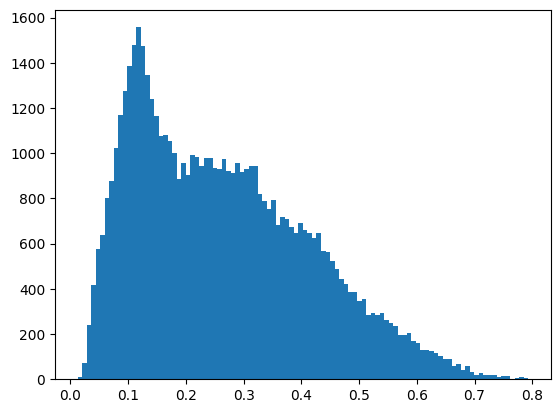

In [370]:
_ = plt.hist(dd,bins=100)

In [346]:
from reconstruct_mesh import *

points_for_recons = points[predict_prob > 0.5]  # filter points with prob > 0.5
predict_uvs_for_recons = predict_uvs[predict_prob > 0.5]  # filter uvs with prob > 0.5

points_for_recons, predict_uvs_for_recons = remove_outliers(points_for_recons, predict_uvs_for_recons,5)

vertices_result = reconstruct_mesh_Knn(points_for_recons,predict_uvs_for_recons, uvs_array, k=40)
reconstructed_mesh = o3d.geometry.TriangleMesh()
reconstructed_mesh.vertices = o3d.utility.Vector3dVector(vertices_result)
reconstructed_mesh.triangles = o3d.utility.Vector3iVector(target_mesh.triangles)
o3d.io.write_triangle_mesh("/root/autodl-tmp/facescape/result/uvs/reconstructed_mesh.ply", reconstructed_mesh)

True

In [14]:
# zero shot on persons that are not from facescape
model = VGGT()
_URL = "./model.pt"
model.load_state_dict(torch.load(_URL))
model.eval()
model = model.to(device)

/tmp/ipykernel_20468/864299653.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(_URL))


In [161]:
path = "./test_model/shadow1_16view"
# path = "/root/autodl-tmp/facescape/mv_image/9"

image_names = sorted(glob.glob(os.path.join(path, "*.png")))
# random.shuffle(image_names)
# image_names = random.sample(image_names, 16)  # Randomly sample 16 images for testing
images = load_and_preprocess_images(image_names).to(device)

In [162]:
with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        images = images[None]  # add batch dimension
        aggregated_tokens_list, ps_idx = model.aggregator(images)
    feature_maps = model.track_head.feature_extractor(aggregated_tokens_list, images, ps_idx)[0]
    feature_maps = torch.nn.functional.interpolate(feature_maps, size=(518, 518), mode='bilinear', align_corners=False)
    feature_maps = feature_maps.permute(0, 2, 3, 1) # 16, 518, 518, 128
    feature_maps_ = feature_maps.detach().cpu().numpy()

/tmp/ipykernel_20468/1291808164.py:2: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):


In [163]:
feature_maps_ = np.load("./feature_maps.npy")

In [164]:
with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        aggregated_tokens_list, ps_idx = model.aggregator(images)
    # Predict Cameras
    pose_enc = model.camera_head(aggregated_tokens_list)[-1]
    # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
    extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images.shape[-2:])

    # Predict Depth Maps
    depth_map, depth_conf = model.depth_head(aggregated_tokens_list, images, ps_idx)
    
    point_map_by_unprojection = unproject_depth_map_to_point_map(depth_map.squeeze(0), 
                                                                extrinsic.squeeze(0), 
                                                                intrinsic.squeeze(0))

/tmp/ipykernel_20468/3541625280.py:2: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):


In [165]:
point_all = point_map_by_unprojection.reshape(-1, 3)
color_all = images[0].permute(0, 2, 3, 1).reshape(-1, 3).detach().cpu().numpy()
conf_all = depth_conf[0].reshape(-1,).detach().cpu().numpy()
threshold = np.median(conf_all)
conf_mask = conf_all > threshold
point_all = point_all[conf_mask]
feature_all = feature_maps_.reshape(-1, 128)[conf_mask]
color_all = color_all[conf_mask]

In [172]:
sample_indices = random.sample(range(point_all.shape[0]), 30000)
points = point_all[sample_indices]
features = feature_all[sample_indices]  # 30000, 128

# predict uvs and prob
features = torch.from_numpy(features).to(device).float()  # 30000, 128
with torch.no_grad():
    predict_output = feature_mlp(features)  # 30000, 3
    predict_uvs = predict_output[..., :2]  # 30000, 2
    predict_prob = predict_output[..., 2]  # 30000
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
colors = apply_color_map(predict_prob.detach().cpu().numpy(), cmap='viridis')
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/uvs/shadow1_16view_points_prob.ply", pcd)
pcd.colors = o3d.utility.Vector3dVector(color_all[sample_indices])
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/uvs/shadow1_16view_points_color.ply", pcd)

highlight_vertex = 4690
highlight_vertex_uv = uvs_array[highlight_vertex]
predict_uvs = predict_uvs.detach().cpu().numpy()
# find the closest point to highlight_vertex_uv in predict_uvs
from scipy.spatial import cKDTree
tree = cKDTree(predict_uvs)
closest_index = tree.query(highlight_vertex_uv)[1]
color = np.zeros((predict_uvs.shape[0], 3), dtype=np.float32)
color[closest_index] = 1
pcd.colors = o3d.utility.Vector3dVector(color)
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/uvs/shadow1_16view_points_highlight.ply", pcd)

True